# Ensemble Methods: Adaptive and Gradient Boosting

Autores: Santander Meteorology Group

## Objetivo:

En la presente práctica trataremos de profundizar en la utilización de los métodos de basados ensembles y compararlos con su contrapartida basada en árboles. Para ello, en primer lugar instalaremos los paquetes asociados a los métodos de ensembles:

install.packages("tree")

install.packages("rpart")

install.packages("rpart.plot")

install.packages("randomForest")

install.packages("adabag")

install.packages("gbm")

install.packages("xgboost")

install.packages("caret")

install.packages("caretEnsemble")

install.packages("MASS")

install.packages("fields")

install.packages("hydroGOF")

install.packages("pROC")

y cargamos las librerías correspondientes:

In [1]:
library(tree) ## arboles
library(rpart) ## Tree-based model
library(rpart.plot) ## Tree-based model
library(randomForest) ## bagging: random forests
library(adabag) ## boosting: adaptive boosting
library(gbm) ## boosting: Gradient boosting
library(xgboost) ## Extreme Gradient Boosting
library(caret)
library(caretEnsemble)
library(MASS)
library(fields) ## Plotting
library(hydroGOF) ## Evaluation
library(pROC) ## Classification Evaluation

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Loading required package: caret

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice

Loading required package: foreach

Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3

Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required pack

A lo largo de la práctica usaremos varios datasets para ejemplificar el uso de las diferentes funciones.

# Clasificación:

Partamos de lo realizado en sesiones anteriores con el dataset `iris`. Cargamos los datos y definimos los conjuntos de `train` y de `test`:

In [2]:
## train/test partition
set.seed(23)
n <- nrow(iris)
indtrain <- sample(1:n, round(0.75*n))  # indices for train
indtest <- setdiff(1:n, indtrain)  # indices for test
trainParams <- trainControl(method = "cv", number = 10)

Ajustamos los diferentes parámetros del árbol independiente:

 * Complexity parameter

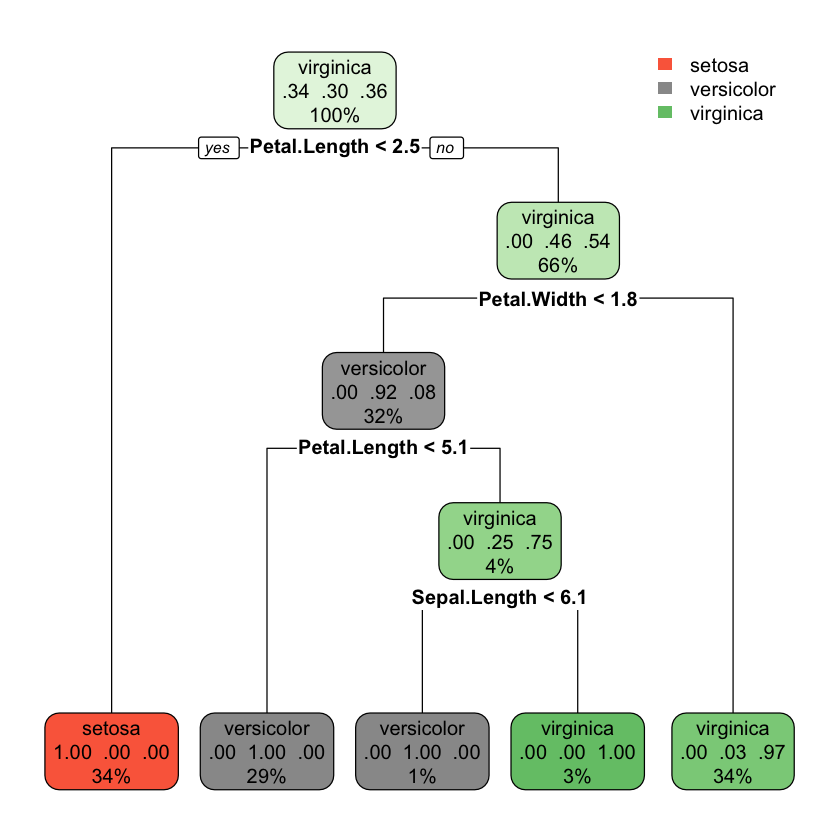

In [4]:
## Single Tree: Adjusting the complexity parameter:
treeGrid <- expand.grid(cp = 10^c(-1:-5))
treeFit.cp <- train(Species ~ .,
                    data=iris,
                    subset = indtrain,
                    method="rpart",
                    trControl=trainParams,
                    tuneGrid = treeGrid, 
                    metric = "Accuracy",
                    control = rpart.control(minsplit = 2, minbucket = 1, maxdepth = 30)
                    )
rpart.plot(treeFit.cp$finalModel)

 * Profundidad

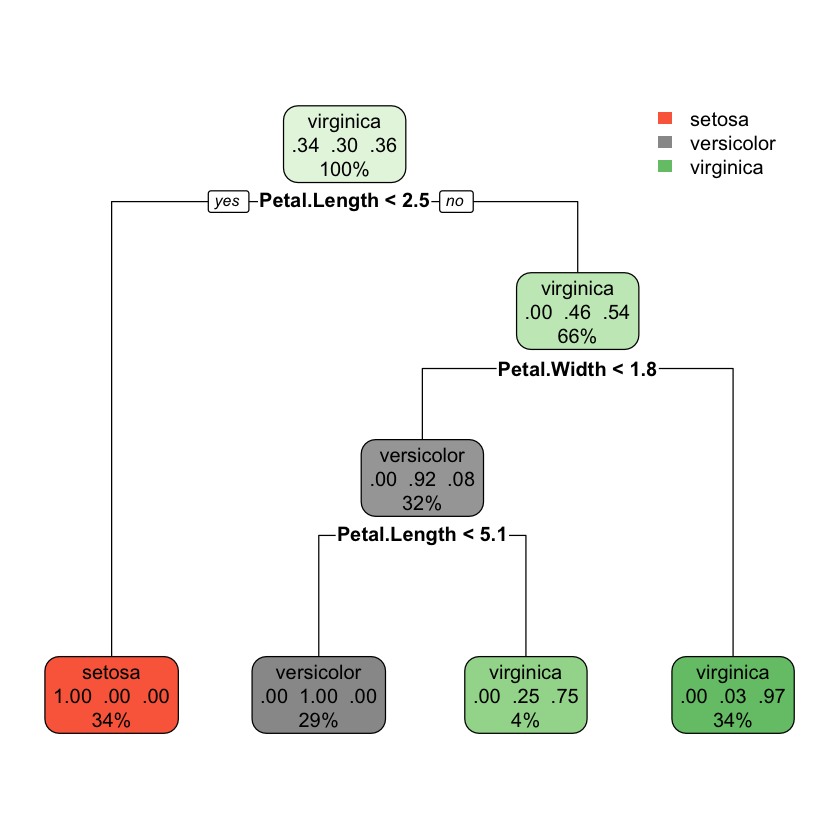

In [5]:
## Single Tree: Adjusting the Maximum Depth:
treeGrid <- expand.grid(maxdepth = c(1:30))
treeFit.md <- train(Species ~ .,
                    data=iris, 
                    subset = indtrain,
                    method="rpart2",
                    trControl=trainParams,
                    tuneGrid = treeGrid, 
                    metric = "Accuracy",
                    control = rpart.control(minsplit = 2, minbucket = 1, cp = treeFit.cp$bestTune$cp)
                    )
rpart.plot(treeFit.md$finalModel)

Usando la configuración identificada aprendemos el árbol final y predecimos y evaluamos sobre ambos conjuntos utilizando:

[1] 0.9473684 0.9821429


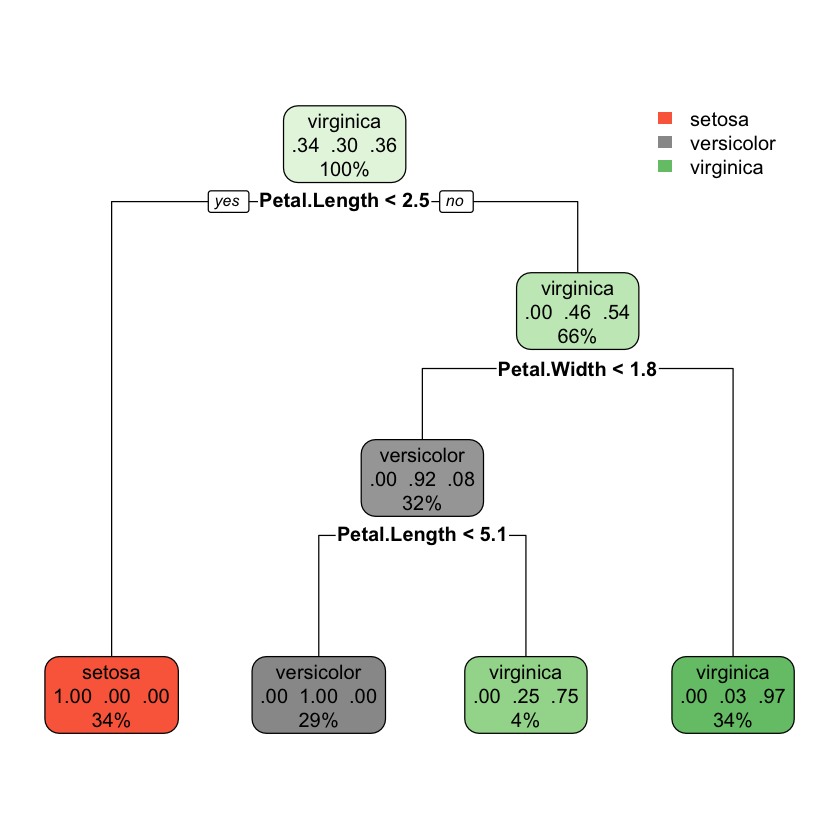

In [6]:
treeFit <- train(Species ~ .,
                data=iris,
                subset = indtrain,
                method="rpart",
                trControl=trainParams,
                metric = "Accuracy",
                control = rpart.control(minsplit = 2, minbucket = 1, cp = treeFit.cp$bestTune$cp, maxdepth = treeFit.md$bestTune$maxdepth)
                )
rpart.plot(treeFit$finalModel)

## Prediction for test
pred.t.test <- predict(treeFit, iris[indtest, ], type = "raw")
## Prediction for train
pred.t.train <- predict(treeFit, iris[indtrain, ], type = "raw")
## Accuracy
print(c(sum(diag(table(pred.t.test, iris$Species[indtest]))) / length(indtest), 
        sum(diag(table(pred.t.train, iris$Species[indtrain]))) / length(indtrain)))

O, de forma más detallada, podemos considerar la matriz de confusión:

In [7]:
confusionMatrix(iris$Species[indtest],pred.t.test)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         0
  virginica       0          2         8

Overall Statistics
                                          
               Accuracy : 0.9474          
                 95% CI : (0.8225, 0.9936)
    No Information Rate : 0.4737          
    P-Value [Acc > NIR] : 4.248e-10       
                                          
                  Kappa : 0.9185          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8889           1.0000
Specificity                 1.0000            1.0000           0.9333
Pos Pred Value              1.0000            1.0000           0.8000
Neg Pred Value              1.0000            0.9091           1.0000
P

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC:

In [8]:
prob.t.test <- predict(treeFit, iris[indtest, ], type = "prob")

roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), prob.t.test$setosa) # roc for binarial prediction
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), prob.t.test$versicolor)
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), prob.t.test$virginica)

auc.t.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))
print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9545455 0.9000000


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

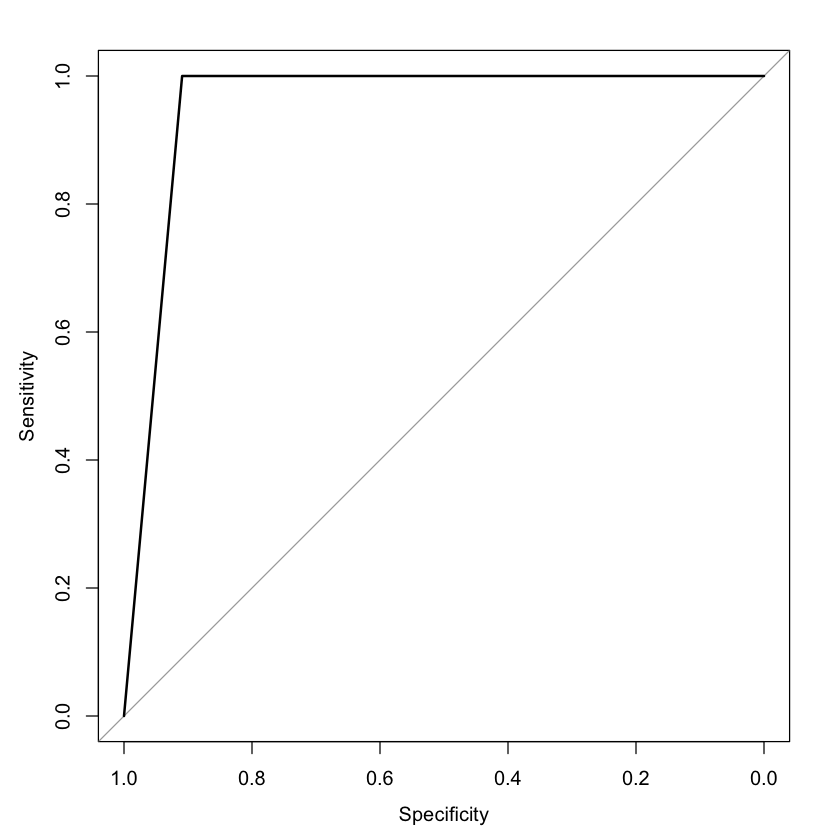

In [10]:
par(bg = "white")
plot(roc_obj.ve)

In [15]:
#prob.t.test # setosa is a categorical variable, we observe this curve because of what's happening from 100

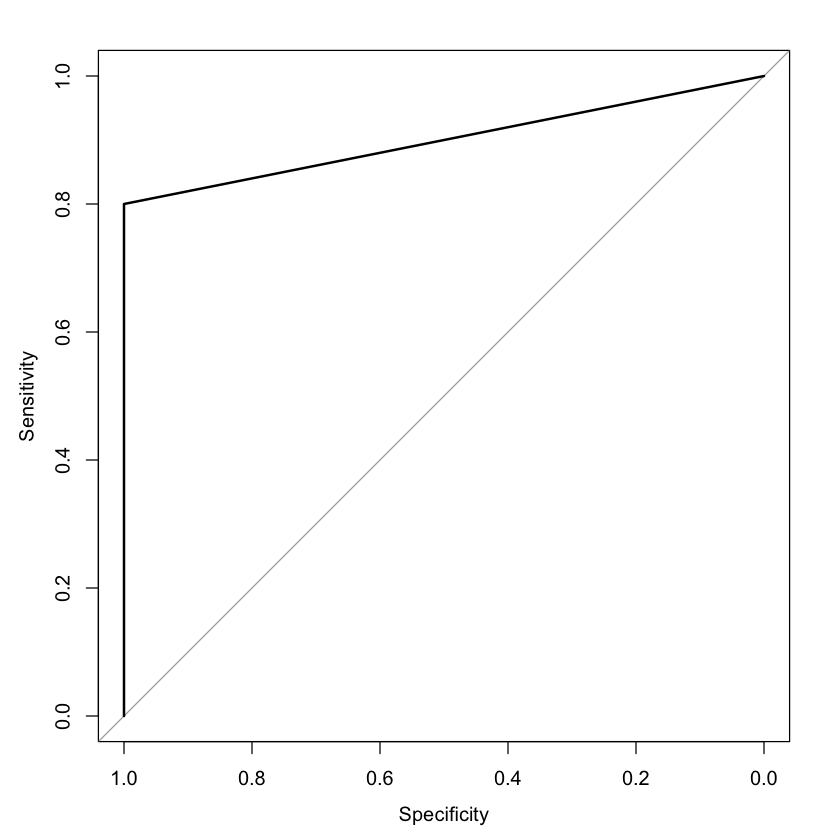

In [11]:
par(bg = "white")
plot(roc_obj.vi)

A continuación, siguiendo con lo visto en la sesión anterior, realizamos la predicción considerando los `random forest` utilizando el valor por defector para el número de variables seleccionadas para cada árbol:

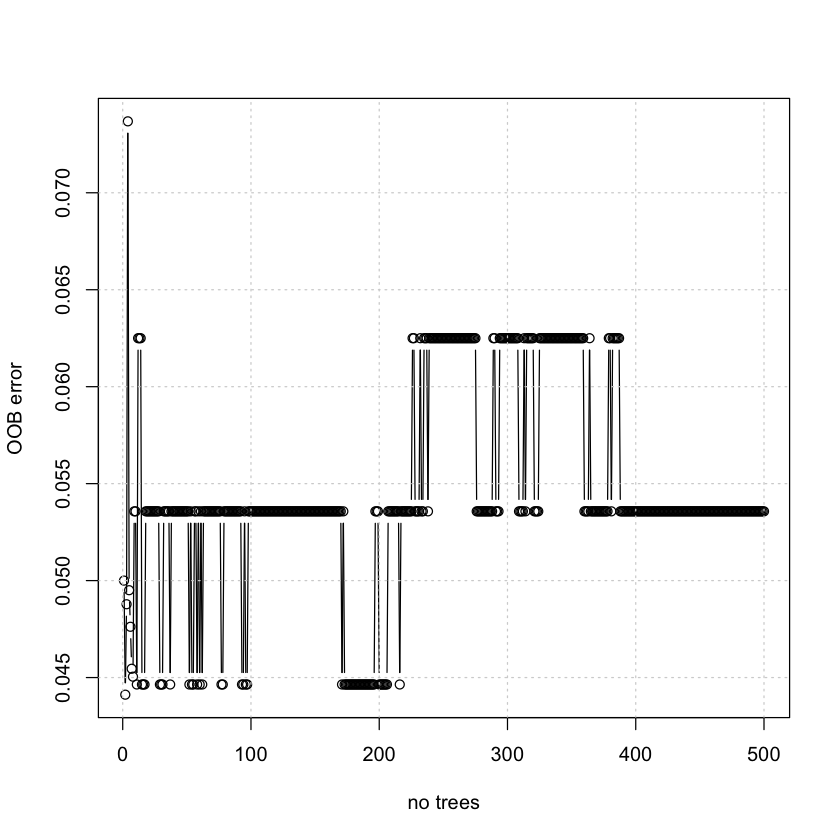

In [ ]:
set.seed(23)
## Bagging: Random Forests: Adjusting the mtry:
rfGrid <- expand.grid(mtry = c(1:3))
rf.m <- train(Species ~ .,
            data=iris,
            subset = indtrain,
            method="rf",
            trControl=trainParams,
            tuneGrid = rfGrid,
            metric = "Accuracy"
            )

## Bagging: Random Forests
rf <- randomForest(Species ~., iris , subset = indtrain, ntree = 500, mtry = rf.m$bestTune$mtry)

# OOB error
par(bg = "white")
plot(rf$err.rate[, 1], type = "b", xlab = "no trees",
ylab = "OOB error")
grid()

A la vista de los resultados consideramos el número de árboles óptimo sobre 100 dado que es la zona de estabilización del parámetros de validación:

In [16]:
## Bagging: Random Forests
rf <- randomForest(Species ~., iris , subset = indtrain, ntree = 100, mtry = rf.m$bestTune$mtry) # 100 trees because is one of the stable zone, where the OOB error si stable

## Prediction for test
pred.rf.test <- predict(rf, iris[indtest, ])
## Prediction for train
pred.rf.train <- predict(rf, iris[indtrain, ])
## Accuracy
print(c(sum(diag(table(pred.rf.test, iris$Species[indtest]))) / length(indtest), 
        sum(diag(table(pred.rf.train, iris$Species[indtrain]))) / length(indtrain)))

[1] 0.9210526 1.0000000


In [17]:
confusionMatrix(iris$Species[indtest],pred.rf.test)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         0
  virginica       0          3         7

Overall Statistics
                                          
               Accuracy : 0.9211          
                 95% CI : (0.7862, 0.9834)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 3.339e-08       
                                          
                  Kappa : 0.8769          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8421           1.0000
Specificity                 1.0000            1.0000           0.9032
Pos Pred Value              1.0000            1.0000           0.7000
Neg Pred Value              1.0000            0.8636           1.0000
P

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC:

In [18]:
prob.rf.test <- predict(rf, iris[indtest, ], type = "prob")

roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), prob.rf.test[,1])
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), prob.rf.test[,2])
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), prob.rf.test[,3])

auc.rf.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))

print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9772727 0.9714286


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

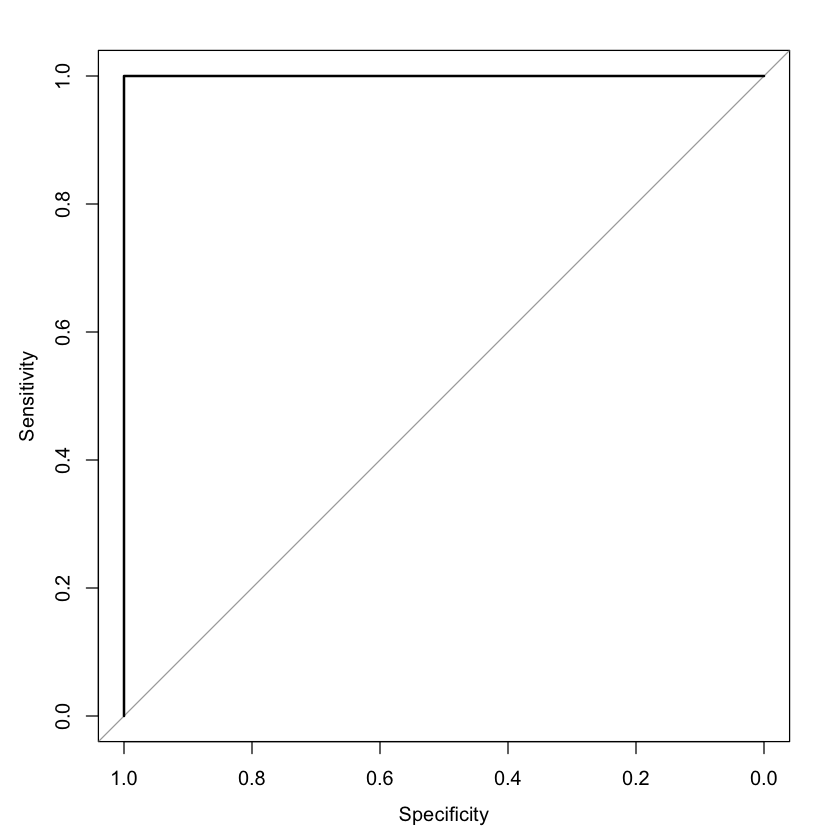

In [19]:
par(bg = "white")
plot(roc_obj.s)

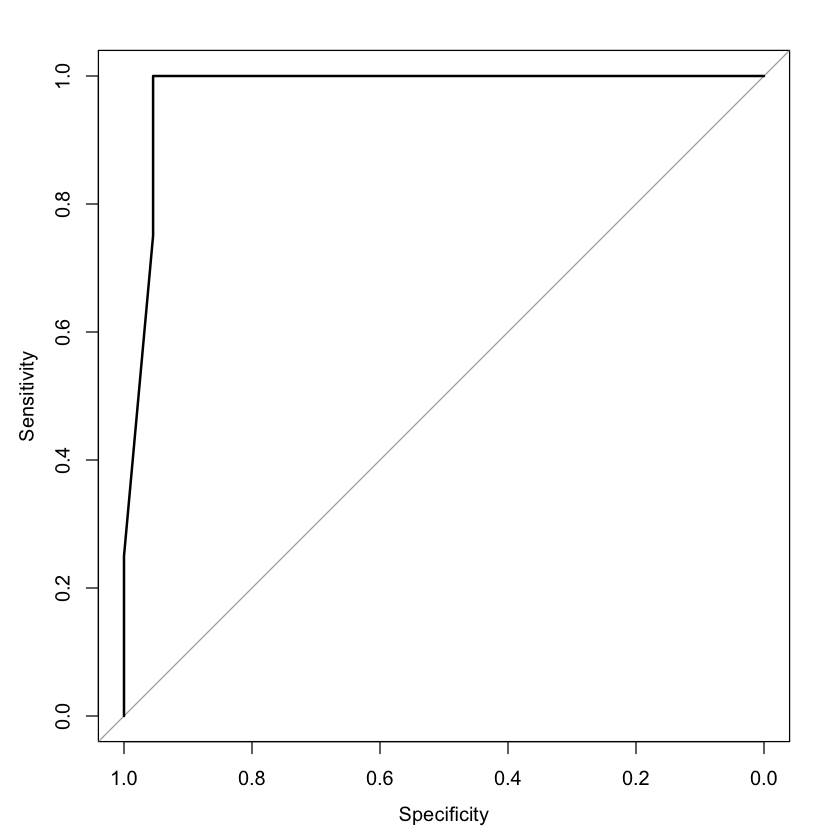

In [20]:
par(bg = "white")
plot(roc_obj.ve)

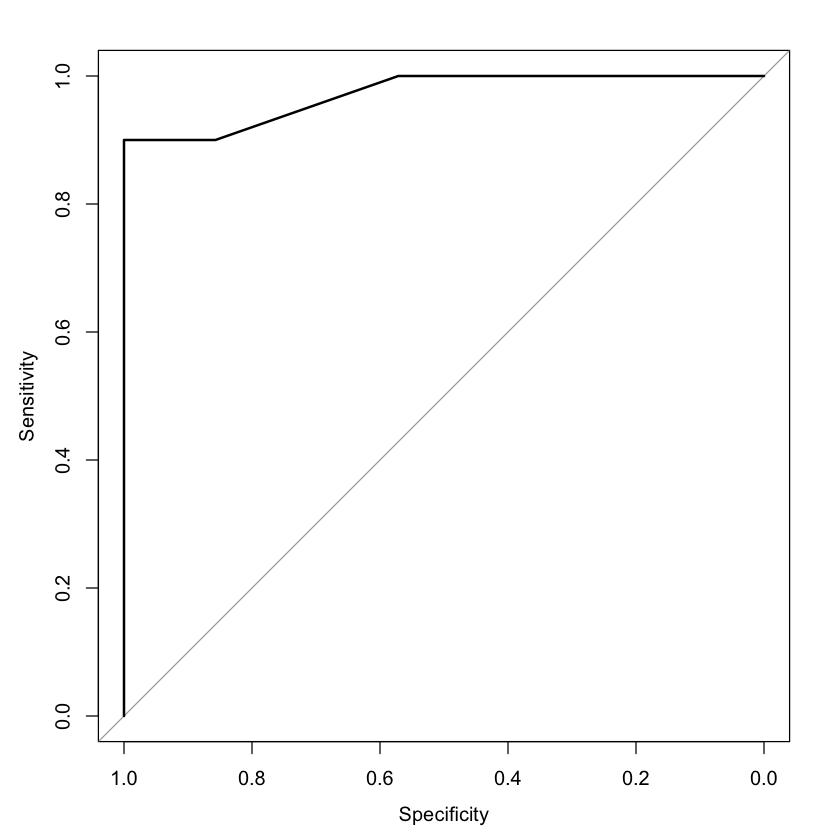

In [21]:
par(bg = "white")
plot(roc_obj.vi)

Consideremos ahora el método estándar de boosting, el Adaptive Boosting (adaboost). Para ello, revisemos inicialmente los parámetros de la función [boosting](https://www.rdocumentation.org/packages/adabag/versions/4.2/topics/boosting):

In [22]:
## Boosting: Adaptive Boosting (AdaBoost)
? boosting

boosting                package:adabag                 R Documentation

_A_p_p_l_i_e_s _t_h_e _A_d_a_B_o_o_s_t._M_1 _a_n_d _S_A_M_M_E _a_l_g_o_r_i_t_h_m_s _t_o _a _d_a_t_a _s_e_t

_D_e_s_c_r_i_p_t_i_o_n:

     Fits the AdaBoost.M1 (Freund and Schapire, 1996) and SAMME (Zhu et
     al., 2009) algorithms using classification trees as single
     classifiers.

_U_s_a_g_e:

       boosting(formula, data, boos = TRUE, mfinal = 100, coeflearn = 'Breiman', 
             control,...)
     
_A_r_g_u_m_e_n_t_s:

 formula: a formula, as in the 'lm' function.

    data: a data frame in which to interpret the variables named in
          'formula'.

    boos: if 'TRUE' (by default), a bootstrap sample of the training
          set is drawn using the weights for each observation on that
          iteration. If 'FALSE', every observation is used with its
          weights.

  mfinal: an integer, the number of iterations for whic

Busca en CARET el método asociado al algoritmo reflejado en la ayuda. ¿Podemos usar lo visto anteriormente para ajustar el Adaptive Boosting?

In [26]:
set.seed(23)
# Adjusting the number of trees (mfinal)
adaGrid <- expand.grid(mfinal = c(1:20), maxdepth = c(1:5), coeflearn = "Breiman")
ada.m <- train(Species ~ ., data=iris, subset = indtrain, method="AdaBoost.M1", trControl=trainParams, tuneGrid = adaGrid, metric = "Accuracy")
ada.m$bestTune

mfinal maxdepth coeflearn
13 13     1        Breiman

Dado el tamaño del dataset, consideremos un número limitado de árboles, pero suficientemente grande, para ver el número óptimo de árboles a utilizar:

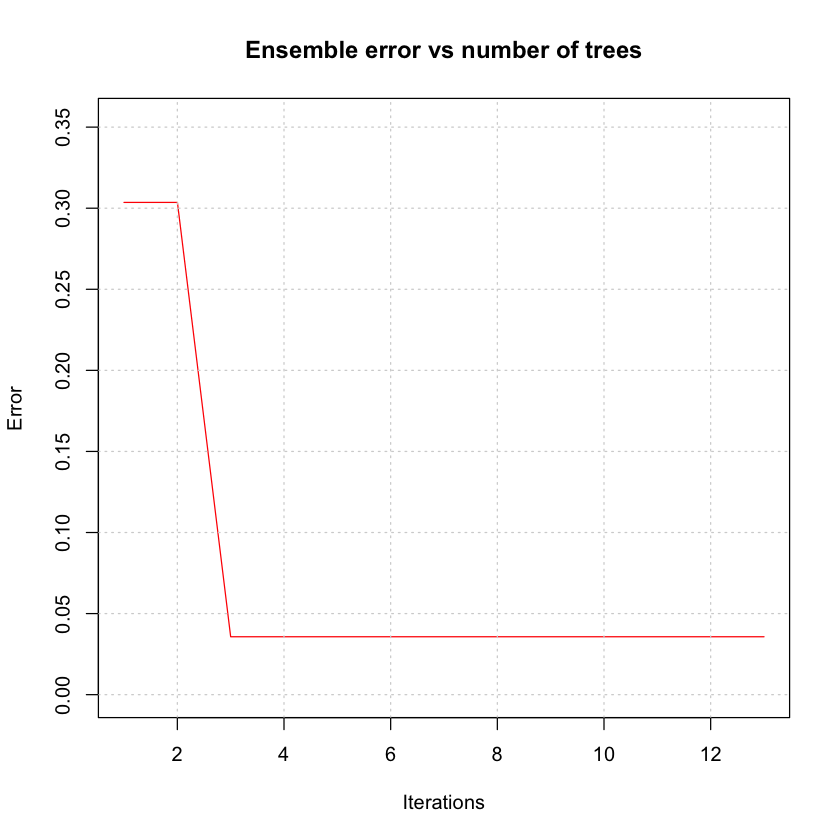

In [27]:
# AdaBoost with 20 trees (mfinal)
ab = boosting(Species ~., iris[indtrain, ], mfinal = ada.m$bestTune$mfinal, boos = FALSE, coeflearn = ada.m$bestTune$coeflearn,
              control = rpart.control(minsplit = 2, minbucket = 1, cp = treeFit.cp$bestTune$cp, maxdepth = ada.m$bestTune$maxdepth))
# train errors as a function of number of trees
par(bg = "white")
plot(errorevol(ab, iris[indtrain, ]))
grid()

Como vemos, a partir de 5 árboles ya el error es nulo, de modo que el número máximo de árboles debe ser a lo sumo 4. Al considerar árboles, y como dice la ayuda, podemos definir los parámetros de control de los árboles construidos con la función `rpart`:

In [28]:
## Boosting: Adaptive Boosting (AdaBoost)
ab <- boosting(Species ~., iris[indtrain, ], mfinal = 4, 
               control=rpart.control(minsplit = 2, minbucket = 1, cp = treeFit.cp$bestTune$cp, maxdepth = ada.m$bestTune$maxdepth))
## Prediction for test
pred.ab.test <- predict(ab, iris[indtest, ])
## Prediction for train
pred.ab.train <- predict(ab, iris[indtrain, ])
## Accuracy
c(sum(diag(table(pred.ab.test$class, iris$Species[indtest]))) / length(indtest), 
  sum(diag(table(pred.ab.train$class, iris$Species[indtrain]))) / length(indtrain))

[1] 0.9473684 0.9732143

In [29]:
## Prediction for test
pred.ab.test <- predict(ab, iris[indtest, ])
## Prediction for train
pred.ab.train <- predict(ab, iris[indtrain, ])
## Accuracy
c(sum(diag(table(pred.ab.test$class, iris$Species[indtest]))) / length(indtest), 
  sum(diag(table(pred.ab.train$class, iris$Species[indtrain]))) / length(indtrain))

[1] 0.9473684 0.9732143

In [30]:
confusionMatrix(iris$Species[indtest],as.factor(pred.ab.test$class))

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         0
  virginica       0          2         8

Overall Statistics
                                          
               Accuracy : 0.9474          
                 95% CI : (0.8225, 0.9936)
    No Information Rate : 0.4737          
    P-Value [Acc > NIR] : 4.248e-10       
                                          
                  Kappa : 0.9185          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8889           1.0000
Specificity                 1.0000            1.0000           0.9333
Pos Pred Value              1.0000            1.0000           0.8000
Neg Pred Value              1.0000            0.9091           1.0000
P

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC. Notar que la predicción es ahora un dataframe, de modo que la probabilidad está incluida en el objeto:

In [31]:
pred.ab.test <- pred.ab.test$prob

roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), pred.ab.test[,1])
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), pred.ab.test[,2])
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), pred.ab.test[,3])

auc.ab.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))
print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9176136 0.9446429


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

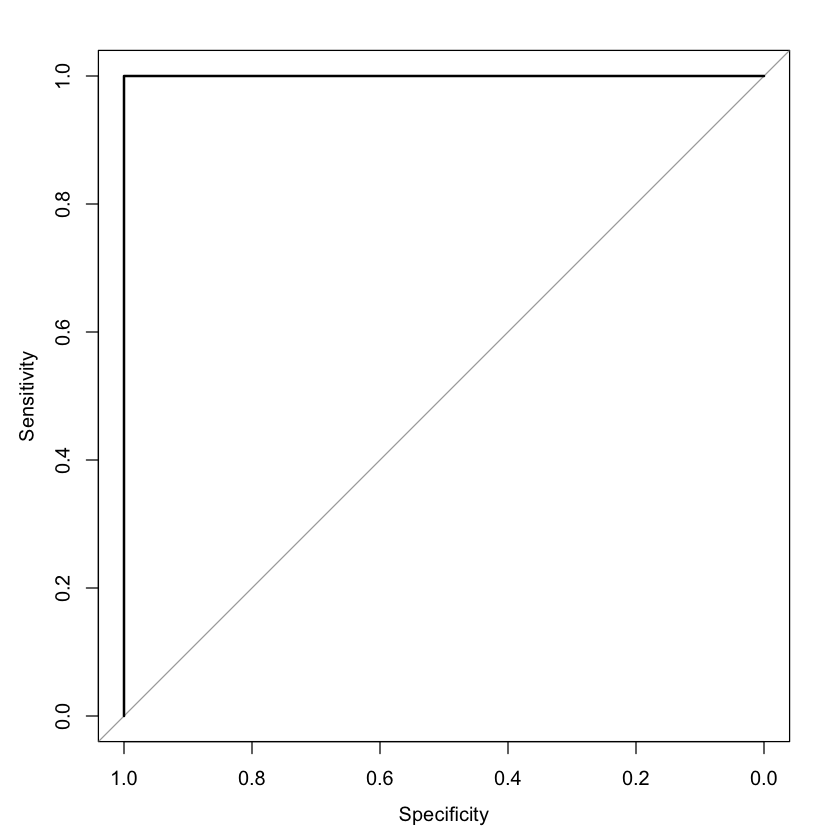

In [33]:
par(bg = "white")
plot(roc_obj.s)

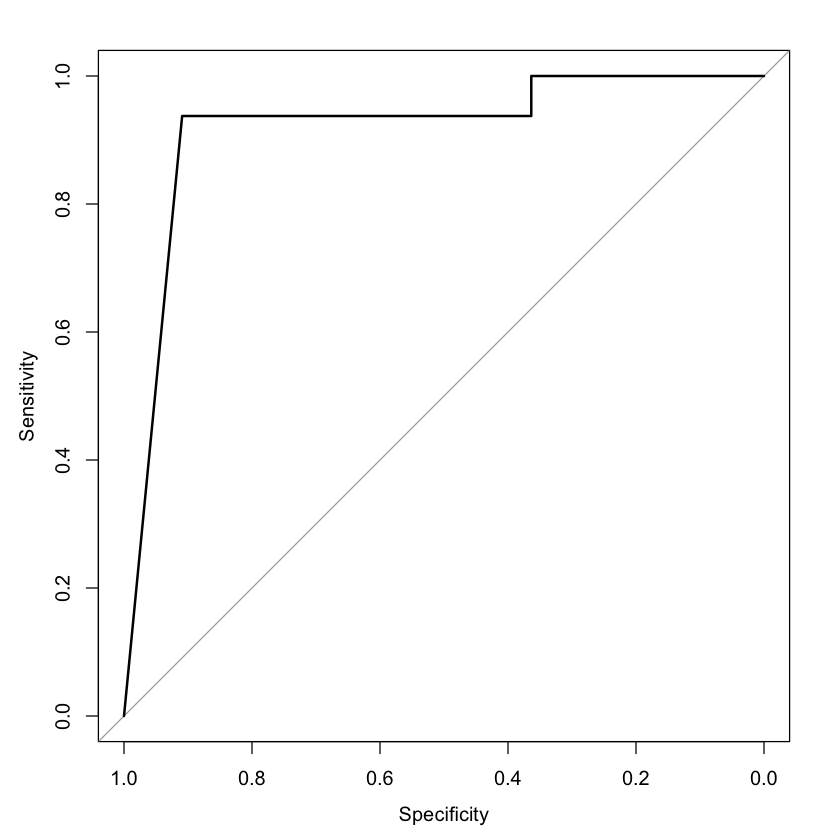

In [34]:
par(bg = "white")
plot(roc_obj.ve)

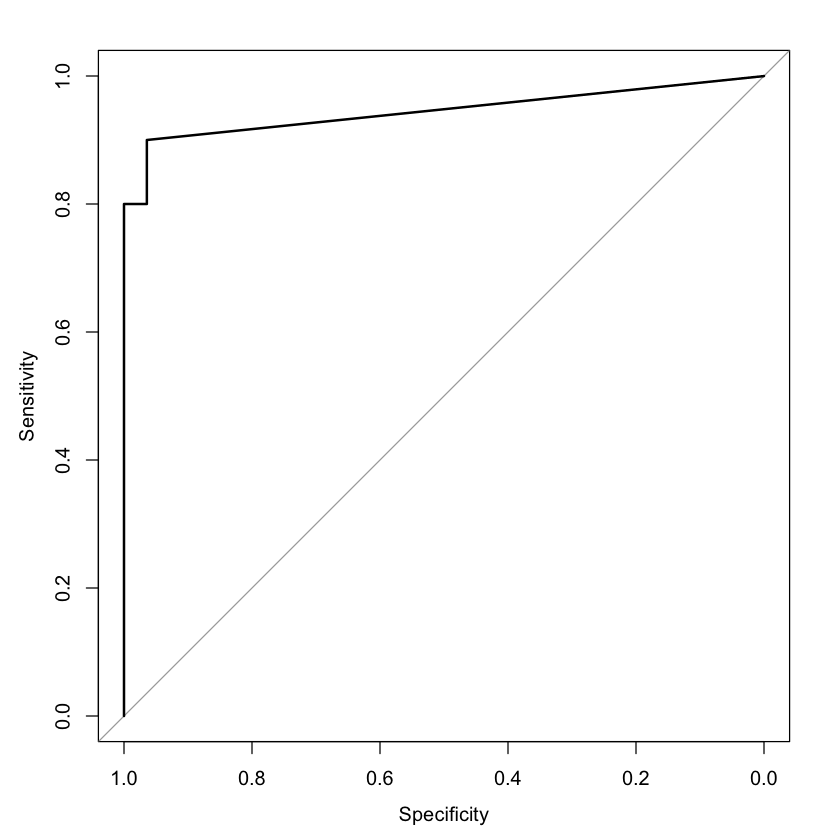

In [35]:
par(bg = "white")
plot(roc_obj.vi)

Finalmente, consideremos el Gradient Boosting para lo cual revisemos los parámetros de la función `gbm`:

In [36]:
? gbm

gbm                    package:gbm                     R Documentation

_G_e_n_e_r_a_l_i_z_e_d _B_o_o_s_t_e_d _R_e_g_r_e_s_s_i_o_n _M_o_d_e_l_i_n_g (_G_B_M)

_D_e_s_c_r_i_p_t_i_o_n:

     Fits generalized boosted regression models. For technical details,
     see the vignette: 'utils::browseVignettes("gbm")'.

_U_s_a_g_e:

     gbm(
       formula = formula(data),
       distribution = "bernoulli",
       data = list(),
       weights,
       var.monotone = NULL,
       n.trees = 100,
       interaction.depth = 1,
       n.minobsinnode = 10,
       shrinkage = 0.1,
       bag.fraction = 0.5,
       train.fraction = 1,
       cv.folds = 0,
       keep.data = TRUE,
       verbose = FALSE,
       class.stratify.cv = NULL,
       n.cores = NULL
     )
     
_A_r_g_u_m_e_n_t_s:

 formula: A symbolic description of the model to be fit. The formula
          may include an offset term (e.g. y~offset(n)+x). If
          'keep.data

Los argumentos base vistos en la sesión teórica se corresponden con:

 * shrinkage
 * n.trees
 * interaction.depth

Si bien hay otros argumentos que permiten el control de las caracteristicas de los arboles, la validacion cruzada o la aleatorizacion del conjunto de entrenamiento. Busca en CARET el método asociado al algoritmo asociabo a `gbm`.

In [37]:
set.seed(23)
# Adjusting the number of trees (mfinal)
gbmGrid <- expand.grid(n.trees = c(1:15), interaction.depth = c(1:5), shrinkage = 10^c(-5:0), n.minobsinnode = 1)
gbm.m <- train(Species ~ ., data=iris, subset = indtrain, method="gbm", trControl=trainParams, tuneGrid = gbmGrid, metric = "Accuracy")
gbm.m$bestTune

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5        1.0985             nan     0.0000    0.0000
     6        1.0985             nan     0.0000    0.0000
     7        1.0985             nan     0.0000    0.0000
     8        1.0985             nan     0.0000    0.0000
     9        1.0984             nan     0.0000    0.0000
    10        1.0984             nan     0.0000    0.0000
    15        1.0983             nan     0.0000    0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold01: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.5521
     2        0.2612             nan     1.0000   -0.9154
     3        0.4031             nan     1.0000   -2.5092
     4        1.2726             nan     1.0000   -0.2726
     5        0.6834             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold01: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7838
     2        0.1227             nan     1.0000   -2.7834
     3        1.0923             nan     1.0000   -2.5784
     4        1.8520             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold01: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.5861
     2        0.2020             nan     1.0000   -9.0876
     3        2.8429             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold01: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9083
     2        0.0845             nan     1.0000  -14.2673
     3        3.4664             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold01: shrinkage=1e+00, interaction.depth=5, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5        1.0985             nan     0.0000    0.0000
     6        1.0985             nan     0.0000    0.0000
     7        1.0985             nan     0.0000    0.0000
     8        1.0985             nan     0.0000    0.0000
     9        1.0984             nan     0.0000    0.0000
    10        1.0984             nan     0.0000    0.0000
    15        1.0983             nan     0.0000    0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold02: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8312
     2        0.2014             nan     1.0000   -0.1312
     3        0.0973             nan     1.0000   -3.8273
     4        1.3327             nan     1.0000   -0.0209
     5        0.7070             nan     1.0000   -4.0287
     6        1.8155             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold02: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8517
     2        0.1954             nan     1.0000   -3.6498
     3        1.3637             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold02: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7888
     2        0.1517             nan     1.0000   -3.5531
     3        1.3695             nan     1.0000    0.0169
     4        1.3556             nan     1.0000    0.0514
     5        1.3323             nan     1.0000    0.0444
     6        1.3132             nan     1.0000   -0.0562
     7        1.3316             nan     1.0000    0.0403
     8        1.3186             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold02: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    1.0509
     2        0.0503             nan     1.0000   -0.0477
     3        0.0216             nan     1.0000   -0.0098
     4        0.0098             nan     1.0000    0.0033
     5        0.0019             nan     1.0000   -0.0014
     6        0.0019             nan     1.0000   -0.0017
     7        0.0016             nan     1.0000   -0.0068
     8        0.0041             nan     1.0000   -0.0000
     9        0.0003             nan     1.0000   -0.0003
    10        0.0002             nan     1.0000    0.0001
    15        0.0000             nan     1.0000   -0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold03: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8611
     2        0.1102             nan     1.0000  -26.5154
     3        8.4826             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold03: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8609
     2        0.1102             nan     1.0000   -0.0984
     3        0.1312             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000   -0.0001
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000    0.0000
    15           nan             nan     1.0000   -0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7680
     2        0.1384             nan     1.0000   -0.1658
     3        0.1480             nan     1.0000   -0.4623
     4        0.1910             nan     1.0000    0.0637
     5       

Warning message:
"predictions failed for Fold03: shrinkage=1e+00, interaction.depth=5, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5        1.0985             nan     0.0000    0.0000
     6        1.0985             nan     0.0000    0.0000
     7        1.0985             nan     0.0000    0.0000
     8        1.0985             nan     0.0000    0.0000
     9        1.0984             nan     0.0000    0.0000
    10        1.0984             nan     0.0000    0.0000
    15        1.0983             nan     0.0000    0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold04: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.5079
     2        0.2447             nan     1.0000   -4.5817
     3        1.5210             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold04: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.2437
     2        0.2893             nan     1.0000   -3.2463
     3        1.9401             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold04: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.6874
     2        0.1595             nan     1.0000    0.0432
     3        0.0190             nan     1.0000    0.0164
     4        0.0048             nan     1.0000    0.0039
     5        0.0007             nan     1.0000    0.0004
     6        0.0002             nan     1.0000   -0.0001
     7        0.0001             nan     1.0000   -0.0013
     8        0.0003             nan     1.0000   -0.0079
     9        0.0018             nan     1.0000   -0.0254
    10        0.0084             nan     1.0000   -0.0486
    15        0.0000             nan     1.0000   -0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7137
     2        0.1556             nan     1.0000   -3.3961
     3        1.3772             nan     1.0000   -0.5836
     4        1.5163             nan     1.0000       nan
     5       

Warning message:
"predictions failed for Fold04: shrinkage=1e+00, interaction.depth=5, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5        1.0985             nan     0.0000    0.0000
     6        1.0985             nan     0.0000    0.0000
     7        1.0985             nan     0.0000    0.0000
     8        1.0985             nan     0.0000    0.0000
     9        1.0984             nan     0.0000    0.0000
    10        1.0984             nan     0.0000    0.0000
    15        1.0983             nan     0.0000    0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold05: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    1.0032
     2        0.0742             nan     1.0000    0.0343
     3        0.0264             nan     1.0000   -0.1889
     4        0.0572             nan     1.0000    0.0099
     5        0.0456             nan     1.0000    0.0097
     6        0.0094             nan     1.0000   -0.0467
     7        0.0231             nan     1.0000    0.0337
     8        0.0112             nan     1.0000   -0.0001
     9        0.0002             nan     1.0000   -0.0015
    10        0.0004             nan     1.0000   -0.0000
    15        0.0001             nan     1.0000   -0.0001

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.6847
     2        0.1556             nan     1.0000    0.0638
     3        0.1200             nan     1.0000   -1.1494
     4        0.4463             nan     1.0000       nan
     5       

Warning message:
"predictions failed for Fold05: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8315
     2        0.1111             nan     1.0000   -0.0247
     3        0.1136             nan     1.0000    0.0015
     4           nan             nan     1.0000    0.0005
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000   -0.0000
     7           nan             nan     1.0000   -0.0057
     8           nan             nan     1.0000   -0.0000
     9           nan             nan     1.0000   -0.0016
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000   -0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold06: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.6121
     2        0.2069             nan     1.0000   -0.0268
     3        0.1957             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold06: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8316
     2        0.1111             nan     1.0000   -0.1048
     3        0.1340             nan     1.0000   -0.0988
     4        0.1661             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold06: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9495
     2        0.0665             nan     1.0000    0.0127
     3        0.0046             nan     1.0000    0.0037
     4        0.0011             nan     1.0000   -0.0074
     5        0.0018             nan     1.0000    0.0017
     6        0.0003             nan     1.0000   -0.0006
     7        0.0002             nan     1.0000   -0.0010
     8        0.0004             nan     1.0000    0.0006
     9        0.0001             nan     1.0000    0.0000
    10        0.0000             nan     1.0000   -0.0002
    15        0.0000             nan     1.0000   -0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold07: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8130
     2        0.1682             nan     1.0000    0.0799
     3        0.0636             nan     1.0000   -0.0261
     4        0.0684             nan     1.0000   -0.2114
     5        0.0828             nan     1.0000   -0.0614
     6        0.0903             nan     1.0000   -0.0574
     7        0.1067             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold07: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9018
     2        0.0885             nan     1.0000   -0.0341
     3        0.0766             nan     1.0000   -4.7638
     4        1.3544             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold07: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9648
     2        0.0573             nan     1.0000    0.0353
     3        0.0125             nan     1.0000    0.0040
     4        0.0042             nan     1.0000   -0.0039
     5        0.0022             nan     1.0000   -0.0018
     6        0.0020             nan     1.0000    0.0003
     7        0.0004             nan     1.0000   -0.0001
     8        0.0003             nan     1.0000   -0.0013
     9        0.0004             nan     1.0000    0.0000
    10        0.0001             nan     1.0000   -0.0006
    15        0.0000             nan     1.0000   -0.0002

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold08: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8284
     2        0.1792             nan     1.0000    0.0807
     3        0.0611             nan     1.0000   -0.1567
     4        0.0577             nan     1.0000   -4.1389
     5        1.4698             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold08: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7279
     2        0.1821             nan     1.0000    0.0583
     3        0.0809             nan     1.0000   -2.0133
     4        0.7245             nan     1.0000    0.1040
     5        0.6812             nan     1.0000    0.3081
     6        0.5437             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold08: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9780
     2        0.0758             nan     1.0000   -0.0209
     3        0.5019             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold08: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9489
     2        0.0711             nan     1.0000    0.0515
     3        0.0376             nan     1.0000   -0.0095
     4        0.0316             nan     1.0000   -0.0656
     5        0.0502             nan     1.0000  -14.6568
     6        4.8978             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold08: shrinkage=1e+00, interaction.depth=5, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5        1.0985             nan     0.0000    0.0000
     6        1.0985             nan     0.0000    0.0000
     7        1.0985             nan     0.0000    0.0000
     8        1.0985             nan     0.0000    0.0000
     9        1.0984             nan     0.0000    0.0000
    10        1.0984             nan     0.0000    0.0000
    15        1.0983             nan     0.0000    0.0000

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.0000    0.0000
     2        1.0986             nan     0.0000    0.0000
     3        1.0986             nan     0.0000    0.0000
     4        1.0985             nan     0.0000    0.0000
     5       

Warning message:
"predictions failed for Fold09: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9968
     2        0.0485             nan     1.0000   -0.0455
     3        0.0383             nan     1.0000   -0.0055
     4        0.0324             nan     1.0000   -1.4523
     5        0.4461             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold09: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.6553
     2        0.1556             nan     1.0000    0.0256
     3        0.0912             nan     1.0000   -1.2804
     4        0.4246             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold09: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8216
     2        0.1342             nan     1.0000    0.0789
     3        0.0259             nan     1.0000    0.0261
     4        0.0074             nan     1.0000   -0.0092
     5        0.0036             nan     1.0000   -0.0411
     6        0.0134             nan     1.0000    0.0240
     7        0.0029             nan     1.0000   -0.0123
     8        0.0029             nan     1.0000   -0.0413
     9        0.0126             nan     1.0000    0.0206
    10        0.0050             nan     1.0000   -0.0000
    15        0.0002             nan     1.0000   -0.0004

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.9496
     2        0.0665             nan     1.0000    0.0108
     3        0.0056             nan     1.0000    0.0043
     4        0.0019             nan     1.0000    0.0002
     5       

Warning message:
"predictions failed for Fold10: shrinkage=1e+00, interaction.depth=1, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.7379
     2        0.1819             nan     1.0000   -2.5362
     3        0.6911             nan     1.0000   -2.6998
     4        1.2941             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold10: shrinkage=1e+00, interaction.depth=2, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8814
     2        0.1157             nan     1.0000   -0.0079
     3        0.0764             nan     1.0000  -11.6674
     4        4.0345             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold10: shrinkage=1e+00, interaction.depth=3, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8312
     2        0.1306             nan     1.0000    0.0092
     3        0.0752             nan     1.0000   -0.0931
     4        0.0926             nan     1.0000    0.0358
     5        0.0519             nan     1.0000   -0.0323
     6        0.0057             nan     1.0000   -0.0428
     7        0.0175             nan     1.0000   -0.2002
     8        0.0479             nan     1.0000  -21.2559
     9        7.0421             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold10: shrinkage=1e+00, interaction.depth=4, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     1.0000    0.8317
     2        0.1111             nan     1.0000  -17.6770
     3        5.2926             nan     1.0000       nan
     4           nan             nan     1.0000       nan
     5           nan             nan     1.0000       nan
     6           nan             nan     1.0000       nan
     7           nan             nan     1.0000       nan
     8           nan             nan     1.0000       nan
     9           nan             nan     1.0000       nan
    10           nan             nan     1.0000       nan
    15           nan             nan     1.0000       nan



Warning message:
"predictions failed for Fold10: shrinkage=1e+00, interaction.depth=5, n.minobsinnode=1, n.trees=15 Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 't': invalid subscript type 'list'
"
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."
Warning message in train.default(x, y, weights = w, ...):
"missing values found in aggregated results"


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.1000    0.3230
     2        0.8597             nan     0.1000    0.2867
     3        0.6651             nan     0.1000    0.1904
     4        0.5317             nan     0.1000    0.1580
     5        0.4251             nan     0.1000    0.1225



n.trees interaction.depth shrinkage n.minobsinnode
365 5       5                 0.1       1

Entrenamos el `gbm` con los parámetros identificados:

In [47]:
## Boosting: Gradient Boosting
gb <- gbm(Species~., data=iris[indtrain, ],
        n.trees=gbm.m$bestTune$n.trees,
        distribution = "multinomial",
        interaction.depth=gbm.m$bestTune$interaction.depth,
        shrinkage = gbm.m$bestTune$shrinkage,
        n.minobsinnode = gbm.m$bestTune$n.minobsinnode
        )

Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."


¿Cuántos árboles seleccionarías?

In [39]:
## Prediction for test
pred.gb.test <- predict(object = gb, newdata = iris[indtest, ], n.trees = gbm.m$bestTune$n.trees, 
                        type = "response")
## Prediction for train
pred.gb.train <- predict(object = gb, newdata = iris[indtrain, ], n.trees = gbm.m$bestTune$n.trees, 
                         type = "response")
## Accuracy
c(sum(diag(table(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.test, FUN = which.max, MARGIN = 1)], 
                 iris$Species[indtest]))) / length(indtest), 
  sum(diag(table(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.train, FUN = which.max, MARGIN = 1)], 
                 iris$Species[indtrain]))) / length(indtrain))

[1] 0.9210526 0.9910714

In [40]:
confusionMatrix(iris$Species[indtest],as.factor(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.test, FUN = which.max, MARGIN = 1)]))

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         0
  virginica       0          3         7

Overall Statistics
                                          
               Accuracy : 0.9211          
                 95% CI : (0.7862, 0.9834)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 3.339e-08       
                                          
                  Kappa : 0.8769          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8421           1.0000
Specificity                 1.0000            1.0000           0.9032
Pos Pred Value              1.0000            1.0000           0.7000
Neg Pred Value              1.0000            0.8636           1.0000
P

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC. Notar que la predicción ya viene por defecto como probabilidad:

In [41]:
roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), pred.gb.test[,1,])
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), pred.gb.test[,2,])
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), pred.gb.test[,3,])

auc.gb.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))
print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1



Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9886364 0.9071429


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

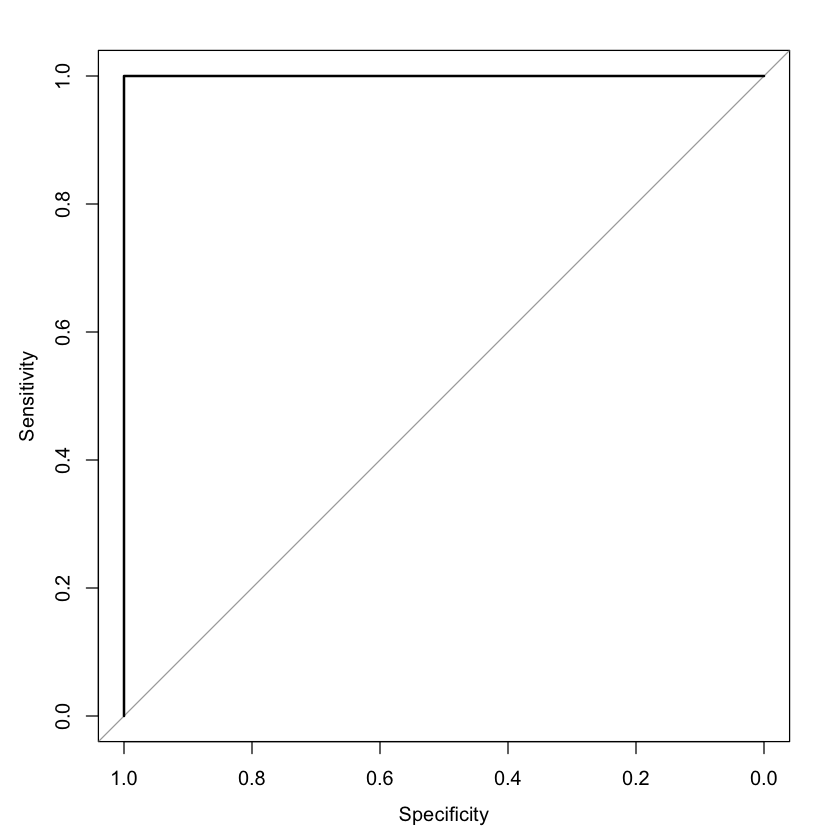

In [42]:
par(bg = "white")
plot(roc_obj.s)

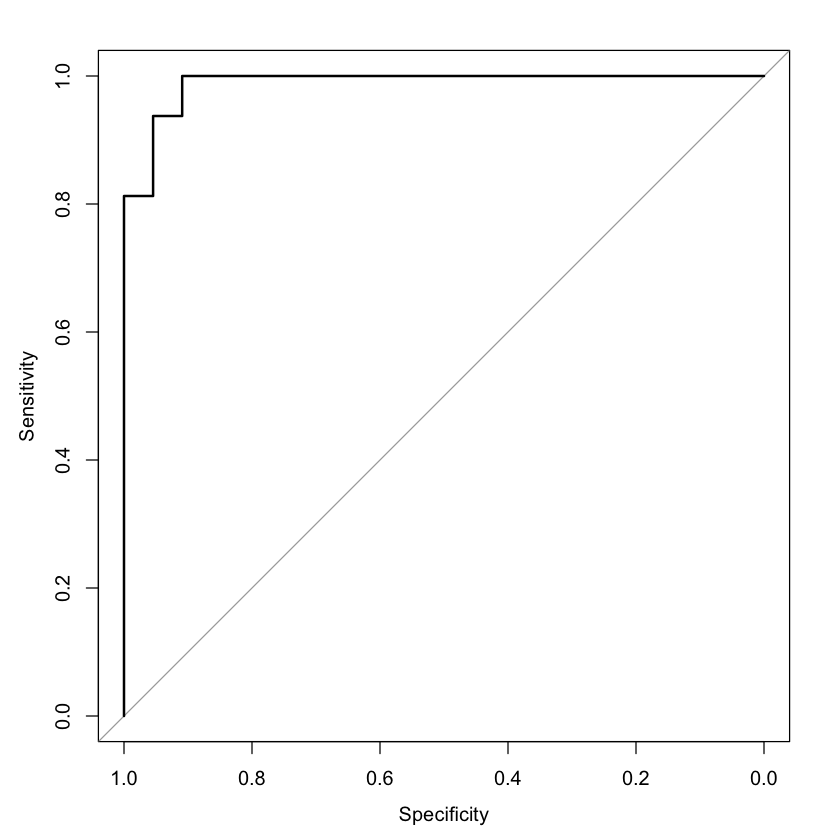

In [43]:
par(bg = "white")
plot(roc_obj.ve)

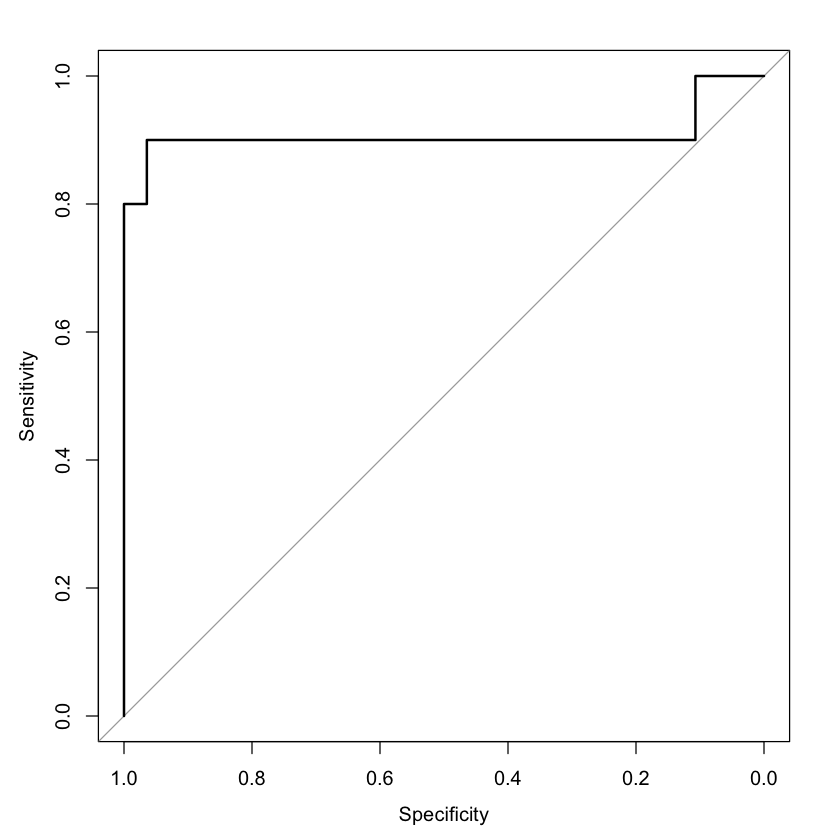

In [44]:
par(bg = "white")
plot(roc_obj.vi)

Como dijimos, pueden incluirse parámetros que controlen la validación cruzada, obteniendo el valor óptimo:

Distribution not specified, assuming multinomial ...


Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."
OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



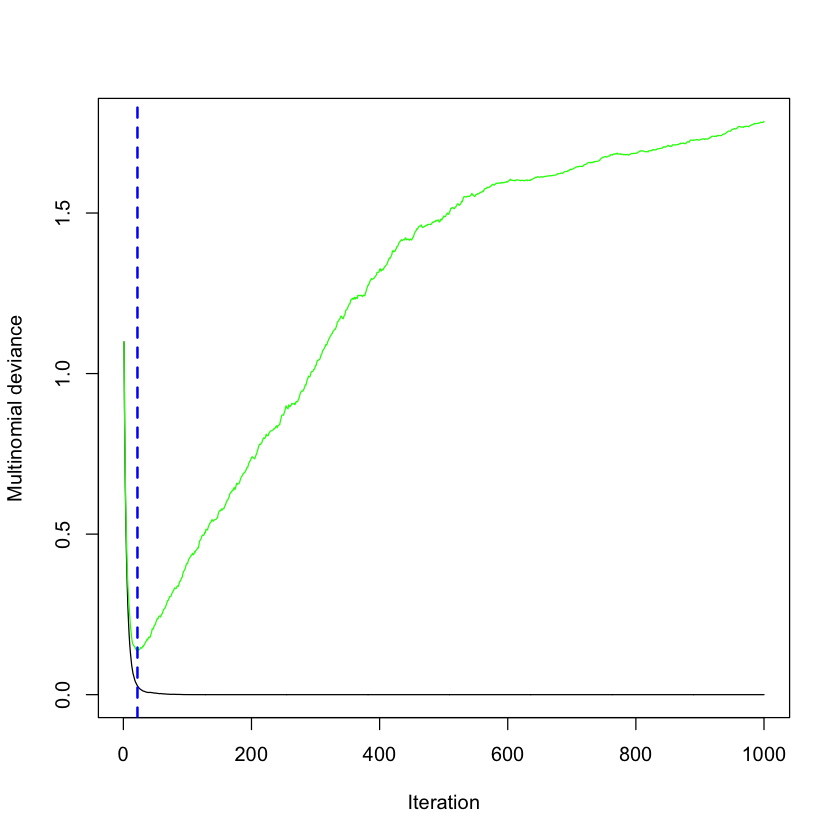

[1] 22
[1] 24
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 1000 
Equivalent Number of Parameters: 40 
Residual Standard Error: 0.00943 


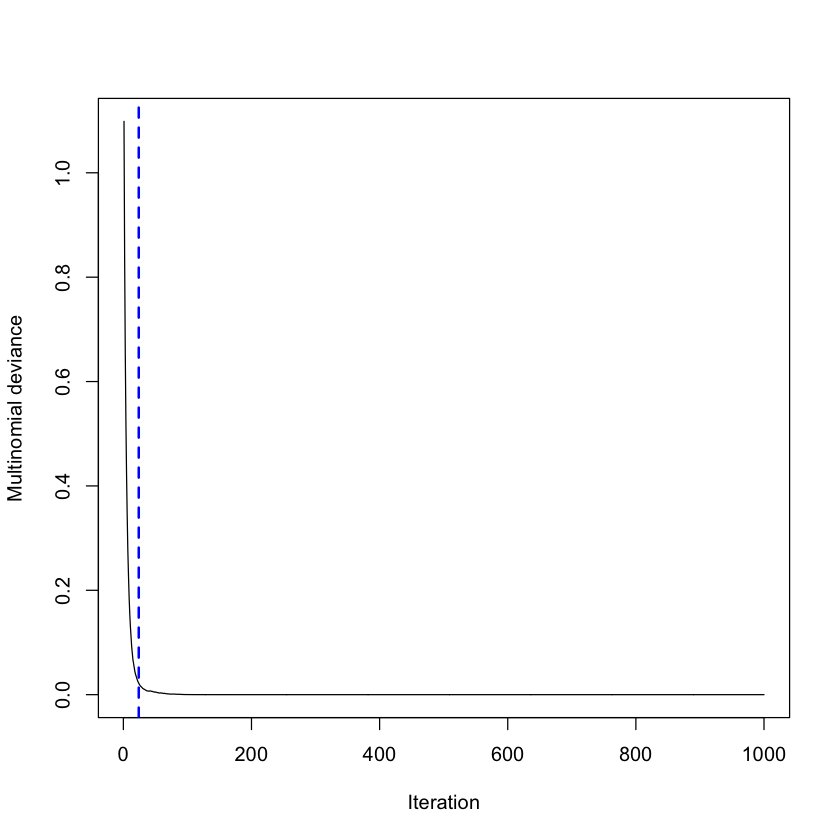

In [ ]:
gb.cv <- gbm(Species~., data=iris[indtrain, ], n.trees=1000, 
             interaction.depth=gbm.m$bestTune$interaction.depth, shrinkage = gbm.m$bestTune$shrinkage,
             n.minobsinnode = gbm.m$bestTune$n.minobsinnode, cv.folds = 10)
ntree_opt_cv <- gbm.perf(gb.cv, method = "cv")
ntree_opt_oob <- gbm.perf(gb.cv, method = "OOB")

print(ntree_opt_cv)
print(ntree_opt_oob)

Que podemos usar en el ajuste:

Distribution not specified, assuming multinomial ...


Warning message:
"Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk."


gbm(formula = Species ~ ., data = iris[indtrain, ], n.trees = ntree_opt_cv, 
    interaction.depth = gbm.m$bestTune$interaction.depth, n.minobsinnode = gbm.m$bestTune$n.minobsinnode, 
    shrinkage = gbm.m$bestTune$shrinkage)
A gradient boosted model with multinomial loss function.
22 iterations were performed.
There were 4 predictors of which 4 had non-zero influence.


var          rel.inf  
Petal.Length Petal.Length 64.851875
Petal.Width  Petal.Width  22.903616
Sepal.Length Sepal.Length  6.826454
Sepal.Width  Sepal.Width   5.418055

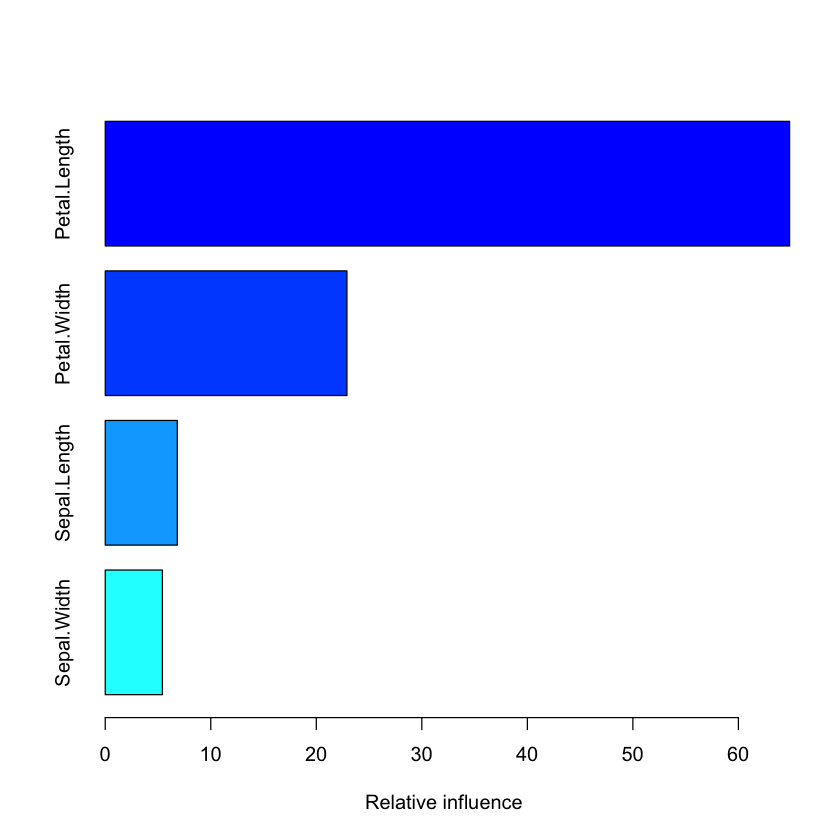

In [48]:
gb <- gbm(Species~., data=iris[indtrain, ], n.trees=ntree_opt_cv, 
          interaction.depth=gbm.m$bestTune$interaction.depth, shrinkage = gbm.m$bestTune$shrinkage,
             n.minobsinnode = gbm.m$bestTune$n.minobsinnode)
print(gb)
summary(gb)

In [49]:
## Prediction for test
pred.gb.test <- predict(object = gb, newdata = iris[indtest, ], 
                        n.trees = ntree_opt_cv, type = "response")
## Prediction for train
pred.gb.train <- predict(object = gb, newdata = iris[indtrain, ], 
                         n.trees = ntree_opt_cv, type = "response")
## Accuracy
c(sum(diag(table(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.test, FUN = which.max, MARGIN = 1)], 
                 iris$Species[indtest]))) / length(indtest), 
  sum(diag(table(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.train, FUN = which.max, MARGIN = 1)], 
                 iris$Species[indtrain]))) / length(indtrain))

[1] 0.9473684 1.0000000

In [50]:
confusionMatrix(iris$Species[indtest],as.factor(attributes(pred.gb.test)$dimnames[[2]][apply(pred.gb.test, FUN = which.max, MARGIN = 1)]))

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         0
  virginica       0          2         8

Overall Statistics
                                          
               Accuracy : 0.9474          
                 95% CI : (0.8225, 0.9936)
    No Information Rate : 0.4737          
    P-Value [Acc > NIR] : 4.248e-10       
                                          
                  Kappa : 0.9185          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8889           1.0000
Specificity                 1.0000            1.0000           0.9333
Pos Pred Value              1.0000            1.0000           0.8000
Neg Pred Value              1.0000            0.9091           1.0000
P

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC. Notar que la predicción ya viene por defecto como probabilidad:

In [51]:
roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), pred.gb.test[,1,])
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), pred.gb.test[,2,])
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), pred.gb.test[,3,])

auc.gb.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))
print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1



Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9914773 0.9892857


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

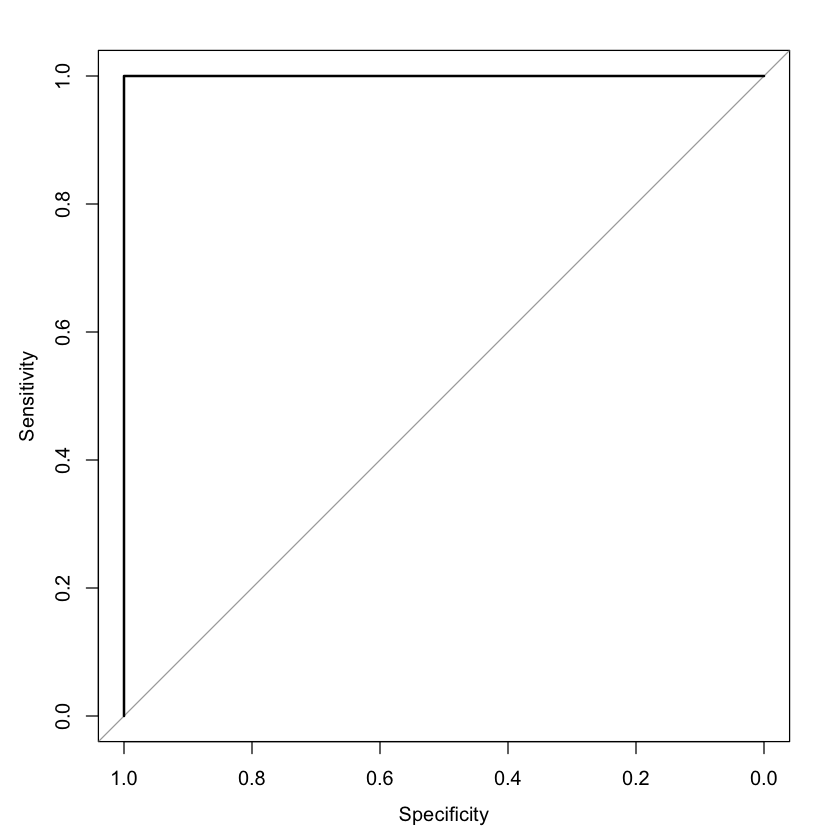

In [52]:
plot(roc_obj.s)

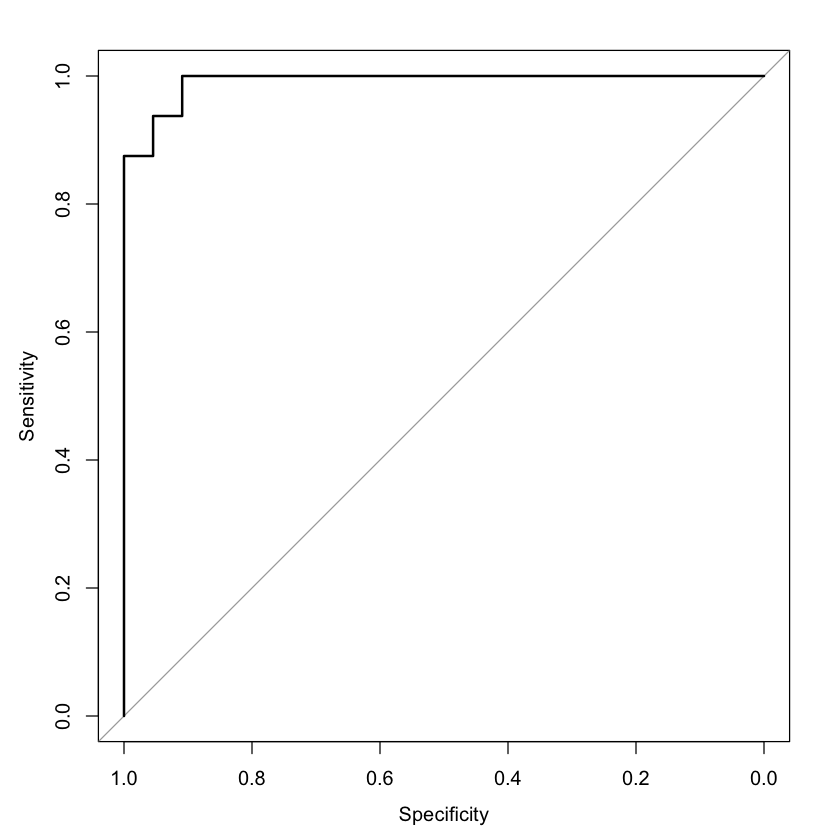

In [53]:
plot(roc_obj.ve)

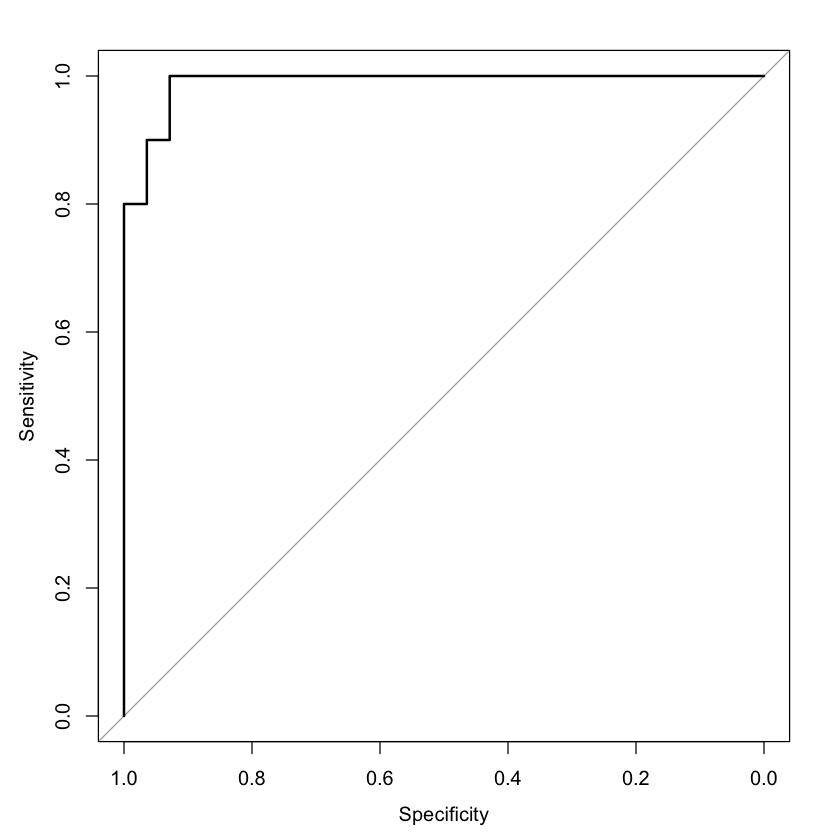

In [54]:
plot(roc_obj.vi)

Identificar en `CARET` los métodos asociados a los modelos anteriores y plantear el aprendizaje de los diferentes métodos con `CARET`, ¿qué parámetros se pueden ajustar? ¿se pierde algún parámetro de ajuste? ¿cuales?

Nuevas implementaciones optimizan el algoritmo realizando el ajuste de forma más eficiente:

In [55]:
install.packages("xgboost") ## Extreme Gradient Boosting

Installing package into '/opt/homebrew/lib/R/4.4/site-library'
(as 'lib' is unspecified)



In [56]:
set.seed(23)
# Adjusting the parameters
xgbGrid <- expand.grid(nrounds = c(1:15), max_depth = c(1:5), eta = 10^c(-5:0), gamma =  10^c(-5:0), colsample_bytree = 1, min_child_weight = 1, subsample = 1)
xgb.m <- train(Species ~ ., data=iris, subset = indtrain, method="xgbTree", trControl=trainParams, tuneGrid = xgbGrid, metric = "Accuracy")
xgb.m$bestTune

[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is deprecated, use `iteration_range` instead.
[19:14:44] WARNING: src/c_api/c_api.cc:935: `ntree_limit` is dep

nrounds max_depth eta gamma colsample_bytree min_child_weight subsample
2252 2       1         1   1e-05 1                1                1

Entrenamos el `gbm` con los parámetros identificados:

In [57]:
## Extreme Gradient Boosting
xgb <- xgboost(data = as.matrix(iris[indtrain,-5]), label = as.matrix(as.numeric(iris$Species[indtrain])-1), max_depth = xgb.m$bestTune$max_depth, 
               eta = xgb.m$bestTune$eta, nrounds = xgb.m$bestTune$nrounds, nthread = 2, objective = "multi:softmax", eval_metric = "merror", verbose = 0,
              gamma =  xgb.m$bestTune$gamma, colsample_bytree = xgb.m$bestTune$colsample_bytree, 
              min_child_weight = xgb.m$bestTune$min_child_weight, subsample = xgb.m$bestTune$subsample, num_class = 3)

In [58]:
## Prediction for test
pred.xgb.test <- predict(xgb, as.matrix(iris[indtest,-5]))  

## Prediction for train
pred.xgb.train <- predict(xgb, as.matrix(iris[indtrain,-5]))

## Accuracy
c(sum(diag(table(as.factor(pred.xgb.test),as.factor(as.numeric(iris$Species[indtest])-1)))) / length(indtest), 
  sum(diag(table(as.factor(pred.xgb.train),as.factor(as.numeric(iris$Species[indtrain])-1)))) / length(indtrain))

[1] 0.9473684 0.9642857

In [59]:
confusionMatrix(as.factor(as.numeric(iris$Species[indtest])-1),as.factor(pred.xgb.test))

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 12  0  0
         1  0 15  1
         2  0  1  9

Overall Statistics
                                          
               Accuracy : 0.9474          
                 95% CI : (0.8225, 0.9936)
    No Information Rate : 0.4211          
    P-Value [Acc > NIR] : 7.335e-12       
                                          
                  Kappa : 0.9195          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.9375   0.9000
Specificity            1.0000   0.9545   0.9643
Pos Pred Value         1.0000   0.9375   0.9000
Neg Pred Value         1.0000   0.9545   0.9643
Prevalence             0.3158   0.4211   0.2632
Detection Rate         0.3158   0.3947   0.2368
Detection Prevalence   0.3158   0.4211   0.2632
Balanced Accuracy      1.0000   0.9460   0.9321

También podemos obtener las probabilidades y usar otras medidas de evalución, como el AUC. Notar que en este caso cambia el argumento objetivo para obtener las probabilidades en lugar de las clases:

In [60]:
xgb <- xgboost(data = as.matrix(iris[indtrain,-5]), label = as.matrix(as.numeric(iris$Species[indtrain])-1), max_depth = xgb.m$bestTune$max_depth, 
               eta = xgb.m$bestTune$eta, nrounds = xgb.m$bestTune$nrounds, nthread = 2, objective = "multi:softprob", eval_metric = "merror", verbose = 0,
              gamma =  xgb.m$bestTune$gamma, colsample_bytree = xgb.m$bestTune$colsample_bytree, 
              min_child_weight = xgb.m$bestTune$min_child_weight, subsample = xgb.m$bestTune$subsample, num_class = 3)

In [61]:
## Prediction for test
prob.xgb.test <- predict(xgb, as.matrix(iris[indtest,-5]))  

roc_obj.s <- roc(as.factor(as.numeric(iris$Species[indtest] == "setosa")), prob.xgb.test[seq(from = 1, to = length(prob.xgb.test), by = 3)])
roc_obj.ve <- roc(as.factor(as.numeric(iris$Species[indtest] == "versicolor")), prob.xgb.test[seq(from = 2, to = length(prob.xgb.test), by = 3)])
roc_obj.vi <- roc(as.factor(as.numeric(iris$Species[indtest] == "virginica")), prob.xgb.test[seq(from = 3, to = length(prob.xgb.test), by = 3)])

auc.xgb.test <- c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi))
print(c(auc(roc_obj.s),auc(roc_obj.ve),auc(roc_obj.vi)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.0000000 0.9744318 0.9678571


¿Qué conclusiones sacas de las siguientes curvas ROC? ¿El árbol aprendido es capaz de discriminar adecuadamente las diferentes clases consideradas? ¿Qué pasa con la clases `Setosa`?

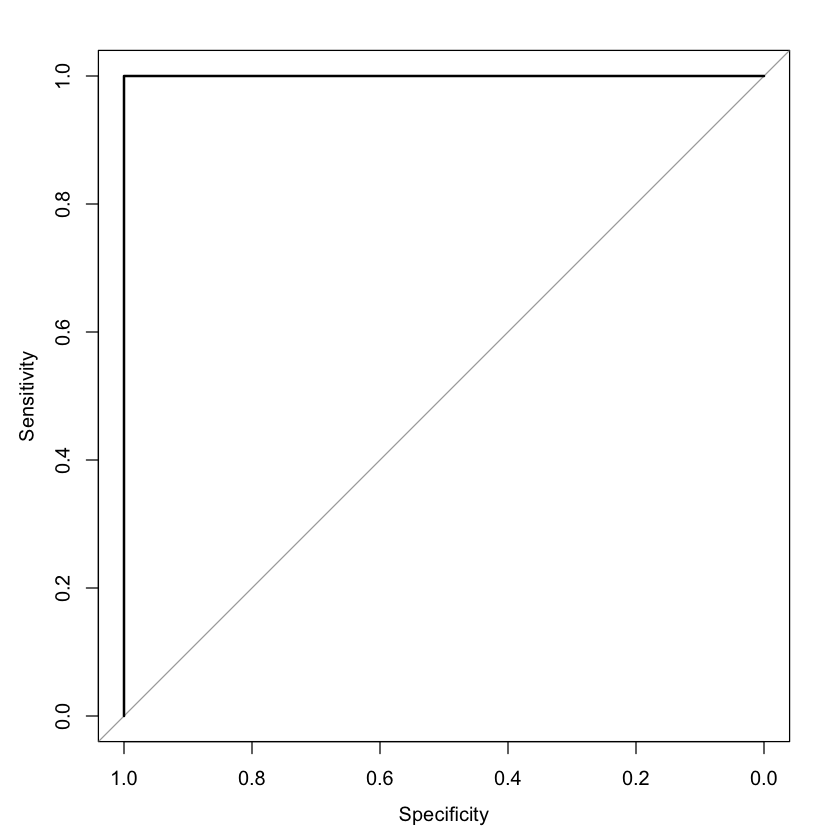

In [62]:
plot(roc_obj.s)

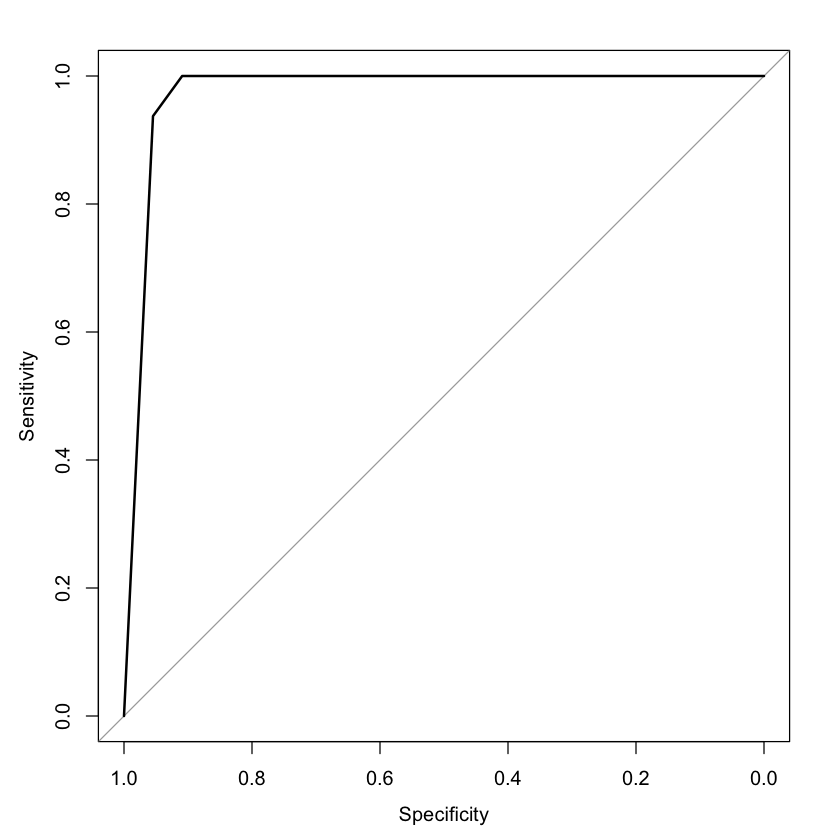

In [63]:
plot(roc_obj.ve)

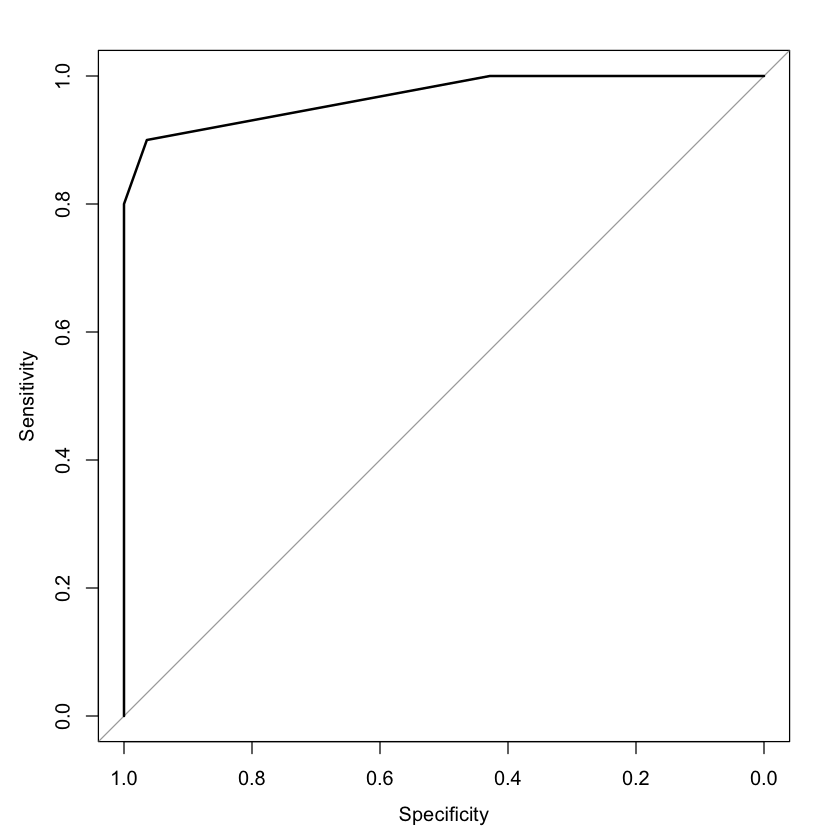

In [64]:
plot(roc_obj.vi)

Miramos la importancia de cada variable:

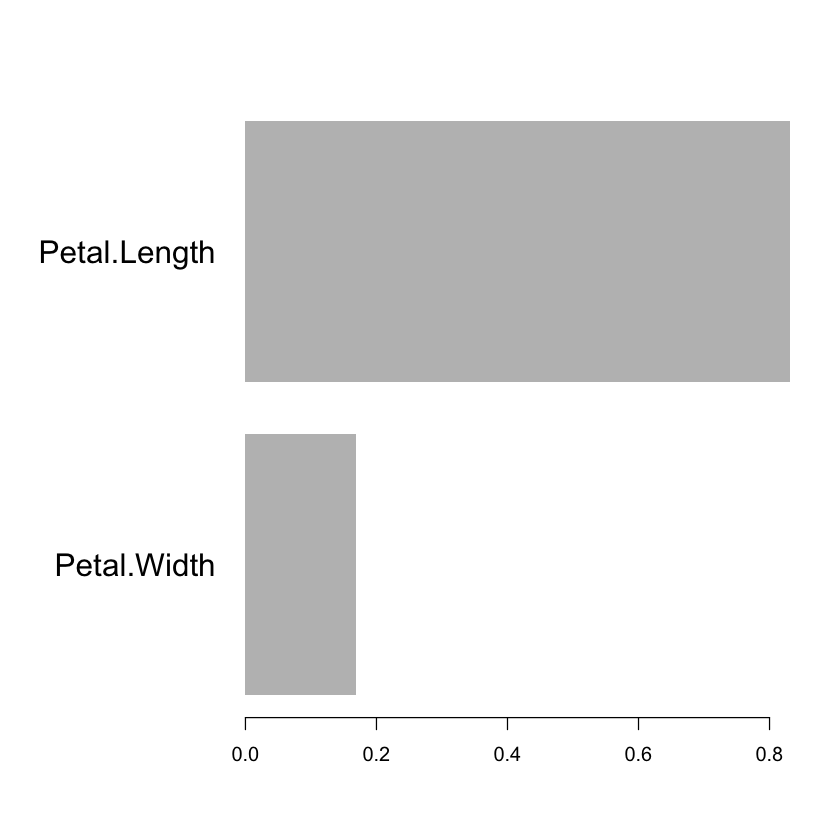

In [65]:
importance_matrix <- xgb.importance(names(iris)[1:4], model=xgb)
xgb.plot.importance(importance_matrix)

Finalmente, saca la tabla resumen y comenta las conclusiones obtenidas:

In [66]:
auc.summary <- matrix(data = NA, nrow = 5, ncol = 3, dimnames = list(c("Tree", "Random Forest", "Adaboost", "Gradient", "Extreme Gradient"),c("Setosa","Versicolor", "Virginica")))
auc.summary[1,] <- auc.t.test
auc.summary[2,] <- auc.rf.test
auc.summary[3,] <- auc.ab.test
auc.summary[4,] <- auc.gb.test
auc.summary[5,] <- auc.xgb.test

print(auc.summary)

                 Setosa Versicolor Virginica
Tree                  1  0.9545455 0.9000000
Random Forest         1  0.9772727 0.9714286
Adaboost              1  0.9176136 0.9446429
Gradient              1  0.9914773 0.9892857
Extreme Gradient      1  0.9744318 0.9678571


## Ejemplo: Meteo dataset
Considera el dataset `Meteo` y extiende lo realizado anteriormente al problema de predicción de precipitaciones en Lisboa a partir de los datos atmosféricos. ¿Cómo cambian los argumentos de las diferentes funciones? ¿Qué efecto tiene la complejidad del problema?

## Session Info:

In [57]:
print(sessionInfo())

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/sixto/anaconda3/envs/climate4R/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Madrid
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pROC_1.18.5          hydroGOF_0.6-0.1     zoo_1.8-12          
 [4] fields_16.3          viridisLite_0.4.2    spam_2.11-0         
 [7] MASS_7.3-60.0.1      caretEnsemble_4.0.1  xgboost_1.7.8.1     
[10] 